# P2: Analyzing the NYC subway dataset

In [75]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


For this project we will explore the NYC subway dataset to achieve the following goals :
     1. Analyze if more people ride the subway when it is raining versus when it is not raining.
     2. Predict the number of entries using linear regression
     3. Explore the dataset using data visualization
     
The dataset can be found [here](https://www.dropbox.com/s/1lpoeh2w6px4diu/improved-dataset.zip?dl=0). It includes information about ridership and also weather.

In [76]:
data=pd.read_csv('improved-dataset/turnstile_weather_v2.csv')

In [77]:
data.head(2)

,UNIT,DATEn,TIMEn,ENTRIESn,EXITSn,ENTRIESn_hourly,EXITSn_hourly,datetime,hour,day_week,...,pressurei,rain,tempi,wspdi,meanprecipi,meanpressurei,meantempi,meanwspdi,weather_lat,weather_lon
0,R003,05-01-11,00:00:00,4388333,2911002,0,0,2011-05-01 00:00:00,0,6,...,30.22,0,55.9,3.5,0,30.258,55.98,7.86,40.700348,-73.887177
1,R003,05-01-11,04:00:00,4388333,2911002,0,0,2011-05-01 04:00:00,4,6,...,30.25,0,52.0,3.5,0,30.258,55.98,7.86,40.700348,-73.887177


What are the variables and format included in the dataset?

In [78]:
data.dtypes

UNIT                object
DATEn               object
TIMEn               object
ENTRIESn             int64
EXITSn               int64
ENTRIESn_hourly    float64
EXITSn_hourly      float64
datetime            object
hour                 int64
day_week             int64
weekday              int64
station             object
latitude           float64
longitude          float64
conds               object
fog                  int64
precipi            float64
pressurei          float64
rain                 int64
tempi              float64
wspdi              float64
meanprecipi        float64
meanpressurei      float64
meantempi          float64
meanwspdi          float64
weather_lat        float64
weather_lon        float64
dtype: object

The description of the variables can be found [here](https://s3.amazonaws.com/uploads.hipchat.com/23756/665149/05bgLZqSsMycnkg/turnstile-weather-variables.pdf).

In [79]:
print "How many records are included in the dataset : ",len(data)

How many records are included in the dataset :  42649


## Section 1. Statistical Test

We would like to analyze if rain has an impact on the ridership of New York's subway.

To measure this effect we can perform a statiscal test where **'ENTRIESn_hourly'** (Difference in ENTRIES from the previous REGULAR reading) is the **dependent variable** and **'rain'** (Indicator (0 or 1) if rain occurred within the calendar day at the location) is the **independent variable**.

In order to choose the right statistical test, it's important to plot the distribution of the two samples (Entries hourly for the rainy day and Entries hourly for the non rainy day).

In [80]:
#Let's create a subset data for rainy days and another for days without rain
with_rain=data[data.rain==1]['ENTRIESn_hourly']
without_rain=data[data.rain==0]['ENTRIESn_hourly']

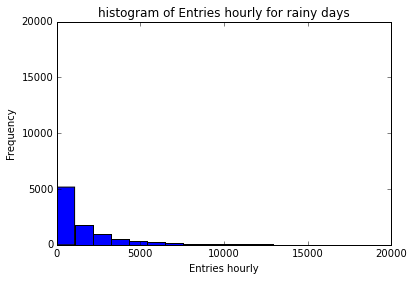

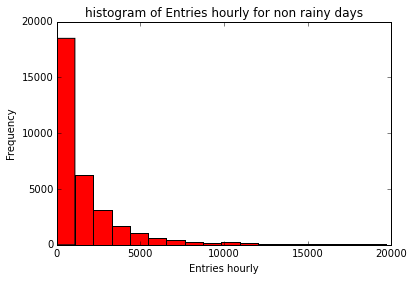

In [81]:
plt.hist(with_rain.values,bins=30)
plt.ylim(0,20000)
plt.xlim(0,20000)
plt.xlabel('Entries hourly')
plt.ylabel('Frequency')
plt.title('histogram of Entries hourly for rainy days')
plt.show()
plt.hist(without_rain.values,bins=30,color='r')
plt.ylim(0,20000)
plt.xlim(0,20000)
plt.xlabel('Entries hourly')
plt.ylabel('Frequency')
plt.title('histogram of Entries hourly for non rainy days')
plt.show()

We can observe that the two samples are not normally distributed. The frequency number of entries equal to 0 is much lower for rainy days than for non-rainy days.

Because the two samples are independent and non-normally distributed, we should perform a non-parametric test such as the Mann-Whitney U-test. We can perform a two-tailed test.  As the Mann-Whitney U-test returns one-tailed p-value, we will have to multiply the p-value by two.

**The null hypothesis is H0 :** the distribution of the population of the number of entries for rainy days is not different from the distribution of the population of the number of entries for non rainy days.

**The alternative hypothesis is HA :** the distribution of the population of the number of entries for rainy days is different from the distribution of the population of the number of entries for non rainy days.

We choose a p-critical value equal to 0.05.

In [82]:
p_critical=0.05

In [83]:
#Let's perform Mann-Whitney U-test.
(U,p)=scipy.stats.mannwhitneyu(with_rain,without_rain)

print "p-value = ",2*p

if 2*p<p_critical:
    print "The null hypothesis is rejected."
else:
    print "The null hypothesis is not rejected."

p-value =  5.48213914249e-06
The null hypothesis is rejected.


We observe that that p-value is inferior to the critical p-value so the null hypothesis is rejected. This means that the population's distribution of the number of entries for rainy days is different from the population's distribution of the number of entries for non rainy days.

We can infer that rain has an effect on ridership in New York City's subway. 

It's interesting to report the mean of the number of hourly entries for rainy day and non rainy day.

In [84]:
print "Mean of the number of hourly entries for rainy day =",np.mean(with_rain)
print "Mean of the number of hourly entries for non rainy day =",np.mean(without_rain)

Mean of the number of hourly entries for rainy day = 2028.19603547
Mean of the number of hourly entries for non rainy day = 1845.53943866


The average number of hourly entries for rainy day tend to be higher for rainy days than non-rainy days.

## Section 2. Linear Regression

We want to predict the number of hourly entries (ENTRIESn_hourly) by using linear regression. We will use OLS (ordinary Least Square) approach using Statsmodels. Documentation can be found [here](http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/ols.html).

In [85]:
import statsmodels.api as sm

### Model 1: Rain + Precipi

We can start by creating a model including the rain and precipitation variables, as we have seen that rain influence ridership of New York City's subway.

In [86]:
X=data[['precipi','rain']]
y=data['ENTRIESn_hourly']

In [87]:
def model_fit(y,X):
    ols_model = sm.OLS(y, X)
    ols_results = ols_model.fit()
    return ols_results

In [88]:
ols_results=model_fit(y,X)
print (ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:        ENTRIESn_hourly   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     1763.
Date:                Wed, 14 Oct 2015   Prob (F-statistic):               0.00
Time:                        22:58:15   Log-Likelihood:            -4.0691e+05
No. Observations:               42649   AIC:                         8.138e+05
Df Residuals:                   42647   BIC:                         8.138e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
precipi    -4634.5194    669.048     -6.927      0.0

In [89]:
print "R-squared = ",ols_results.rsquared

R-squared =  0.0763505915031


We observe that the R-Squared is equal to 0.076. The variable 'rain' and 'precipi' explain only 7.6% of the variance of the model.

### Model 2:  Rain + Precipi + Hour
We can imagine the time of day (hour) has a huge influence on ridership. Let's see if the variable improves R-squared.

In [90]:
#We add the 'hour' variable in the model.
X=data[['precipi','rain','hour']]
ols_results2=model_fit(y,X)
print (ols_results2.summary())

                            OLS Regression Results                            
Dep. Variable:        ENTRIESn_hourly   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     7311.
Date:                Wed, 14 Oct 2015   Prob (F-statistic):               0.00
Time:                        22:58:15   Log-Likelihood:            -3.9975e+05
No. Observations:               42649   AIC:                         7.995e+05
Df Residuals:                   42646   BIC:                         7.995e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
precipi     -705.0458    566.522     -1.245      0.2

In [91]:
print "R-squared = ",ols_results2.rsquared 

R-squared =  0.339632525773


We observe that R-squared has increased from 0.076 to 0.339 by adding 'hour' variable. 

### Model 3 :  Rain + Precipi + Hour + Unit

The weather and time ('hour' variable) have an influence on ridership, but probably certain stations are entered more often than others. The "UNIT" variable is a good proxi of the station.

As the "UNIT" variable is a categorical variable, we need to create dummy variables. 

In [92]:
#We create dummy variable for UNIT
unit_dummy=pd.get_dummies(data.UNIT,prefix="UNIT")
#We concatenate dummy variables with the other variables already included in the model.
X=pd.concat([X,unit_dummy],axis=1)

In [93]:
#We observe that the dummy variables have been added
X.head(2)

,precipi,rain,hour,UNIT_R003,UNIT_R004,UNIT_R005,UNIT_R006,UNIT_R007,UNIT_R008,UNIT_R009,...,UNIT_R373,UNIT_R382,UNIT_R424,UNIT_R429,UNIT_R453,UNIT_R454,UNIT_R455,UNIT_R456,UNIT_R459,UNIT_R464
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
ols_results3=model_fit(data['ENTRIESn_hourly'],X)
print (ols_results3.summary())

                            OLS Regression Results                            
Dep. Variable:        ENTRIESn_hourly   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     149.2
Date:                Wed, 14 Oct 2015   Prob (F-statistic):               0.00
Time:                        22:58:21   Log-Likelihood:            -3.8816e+05
No. Observations:               42649   AIC:                         7.768e+05
Df Residuals:                   42406   BIC:                         7.789e+05
Df Model:                         242                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
precipi    -2741.6119    435.668     -6.293      0.0

In [95]:
print "R-squared = ",ols_results3.rsquared 

R-squared =  0.459955445901


We observe that R-squared has increased from 0.339 to 0.459 by adding 'UNIT' variable. 

### Coefficients
Let's have a closer look at the coefficients for non-dummy variables.

In [96]:
print ols_results3.params[0:3]

precipi   -2741.611866
rain        231.747234
hour        122.218168
dtype: float64


We observe that the 'rain' variable has a positive coefficient. When it rains the number of entries hourly is higher. However the variable 'precipi' (Precipitation in inches at the time and location) has a negative coefficient. One of the reasons could be that when the intensity of the rain is very high, people tend to use the subway less. Finally, we can observe that 'hour' variable has a positive coefficient, the reason for which is intuitive. People are using the subway more at 6pm than at 4am.

### Residuals against predicted values plot

When a linear regression is performed, it's always important to [plot the residuals](http://www.itl.nist.gov/div898/handbook/pri/section2/pri24.htm) in order to make sure that the underlying assumptions of the linear model are satisfied. For example: independence of the error term or constant variance of the error term.

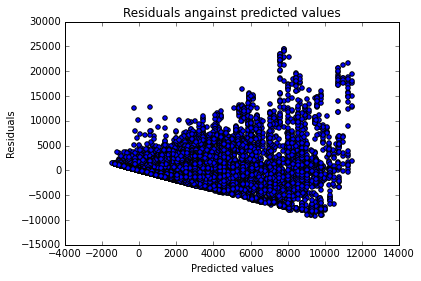

In [97]:
plt.scatter(ols_results3.predict(),ols_results3.resid)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals angainst predicted values')

We notice the residuals have a funnel shape instead of being randomly distributed. It's often a sign of heteroscedasticity, which is when the variance in the errors is non-constant.

A transformation of the outcome variable can often solve this problem. To find the appropriate transformation, we should plot a histogram of the outcome variable ('ENTRIESn_hourly').

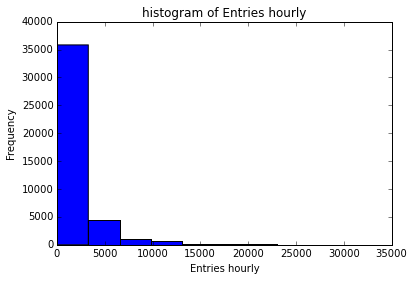

In [98]:
plt.hist(data.ENTRIESn_hourly)
plt.xlabel('Entries hourly')
plt.ylabel('Frequency')
plt.title('histogram of Entries hourly')
plt.show()

ENTRIESn_hourly is right-skewed and has a large range of values. The appropriate transformation is the logarithm transform. As ENTRIESn_hourly is often equal to 0 we can add a small constant equal to 1.

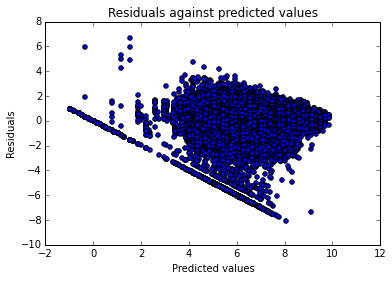

R-squared =  0.477167290685


In [99]:
#Log transformation of the'ENTRIESn_hourly' with a constant of 1.
y=np.log(data['ENTRIESn_hourly']+1)

ols_results4=model_fit(y,X)
#print (ols_results4.summary())
plt.scatter(ols_results4.predict(),ols_results4.resid)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals against predicted values')
plt.show()

print "R-squared = ",ols_results4.rsquared 

We observe that R-Squared has sligtly increased from 0.459 to 0.477. The funnel shape has disappeared. However we can see that certain patterns remain in the residuals. For example, there is a diagonal line of points that is clustered away from the rest of the data. 

This plot suggests that more investigation is necessary to improve the model, such as cleaning the data or transforming the predictors (polynomial,log). 

### What does this R2 value mean for the goodness of fit for your regression model? Do you think this linear model to predict ridership is appropriate for this dataset, given this R2  value?

The quality of linear regression fit is usually assessed by two quantities: residual standard error (RSE) and R-squared statistic. R-squared is the proportion of variance explained by the model. It always takes on a value between 0 and 1. In the last model, R-squared is equal to 0.477 which means that 47.7% of the variance is explained by the model, but 52.3% of the variance remains unexplained. We have already built an interesting model but there is clearly room for improvement. 

We could include more variables, for example 'day_week'. The number of entries hourly is probably different between weekday and weekend. We could also add interactions (beween hour and UNIT) and transfom predictors (polynomial). These avenues may improve R-squared, however it's important to make sure not to overfit. One tactic would be to split the dataset between a train set and a test set. Then train the model on the training set, predict the outcome on the test set, and compute residual standard error (RSE) on the test set to make sure the RSE is decreasing and we don't overfit.

## Section 3. Visualization

In [100]:
from ggplot import *

### Average number of entries by hour

In [101]:
#We aggregate the dataset to have the average number of entries by hour
avg_ENTRIESn_hourly=data.groupby("hour").ENTRIESn_hourly.mean()

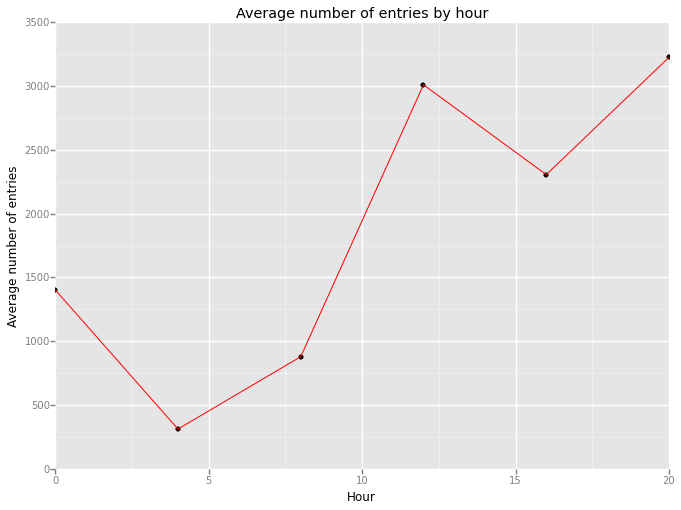

<ggplot: (296175749)>

In [102]:
ggplot(avg_ENTRIESn_hourly,aes(avg_ENTRIESn_hourly.index,avg_ENTRIESn_hourly.values))+geom_point() + geom_line(color="red") +\
xlab("Hour")+ ylab("Average number of entries")+ggtitle("Average number of entries by hour")+xlim(0,20)

As expected the subway is very busy in the morning around 10am and during the evening around 6pm. The subway is less busy during mid-afternoon and at night.

### Average number of entries hourly by day

In [103]:
AVG_ENTRIESn_hourly_by_day=data.groupby("day_week").ENTRIESn_hourly.mean()

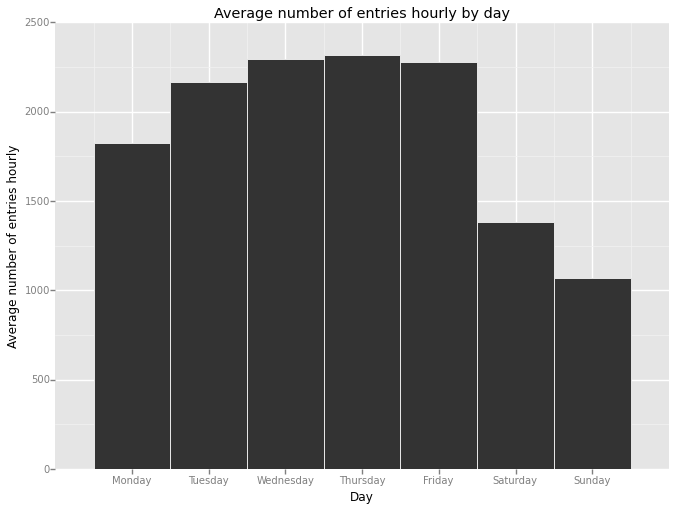

<ggplot: (296174353)>

In [104]:
ggplot(AVG_ENTRIESn_hourly_by_day,aes(x=AVG_ENTRIESn_hourly_by_day.index,y=AVG_ENTRIESn_hourly_by_day.values))+geom_bar(stat = "identity")\
+ xlab("Day")+ ylab("Average number of entries hourly")+ggtitle("Average number of entries hourly by day") +scale_x_discrete(breaks=range(0,7,1),
labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

The subway is less busy during the weekend.

### Busiest subway stations

Another interesting visualization would be to plot the busiest station on a map.

In [105]:
from mpl_toolkits.basemap import Basemap

Let's compute the average number of entries hourly by station. We can select the top 15.

In [106]:
result=data.groupby(['station','latitude','longitude']).ENTRIESn_hourly.mean().reset_index()
result=result.sort('ENTRIESn_hourly',ascending=False).head(15)

In [107]:
result

,station,latitude,longitude,ENTRIESn_hourly
72,59 ST-COLUMBUS,40.768110,-73.981891,10046.634409
56,42 ST-GRD CNTRL,40.751849,-73.976945,8360.844086
179,MAIN ST,40.759578,-73.830056,8359.172043
51,34 ST-HERALD SQ,40.749533,-73.987899,7851.846774
209,ROOSEVELT AVE,40.746655,-73.891361,7808.481081
57,42 ST-PA BUS TE,40.757303,-73.989787,7366.804348
233,WORLD TRADE CTR,40.712557,-74.009807,7245.844086
84,86 ST,40.779485,-73.955541,6831.069892
61,47-50 ST-ROCK,40.758652,-73.981311,6389.865591
58,42 ST-TIMES SQ,40.755905,-73.986504,6363.830189


In [108]:
#We create a dictionary with a color associated to each station
color_list=['green','silver','mediumturquoise','yellow','palegoldenrod',
            'cornsilk','orangered','coral','olive','darkgoldenrod','deepskyblue','brown','seashell','chocolate','purple']

dict_color={}
i=0
for stat in result.station.unique():
    dict_color[stat]=color_list[i]
    i+=1

http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=-74.0414,40.665,-73.7601,40.8424&bboxSR=4326&imageSR=4326&size=1500,945&dpi=96&format=png32&f=image


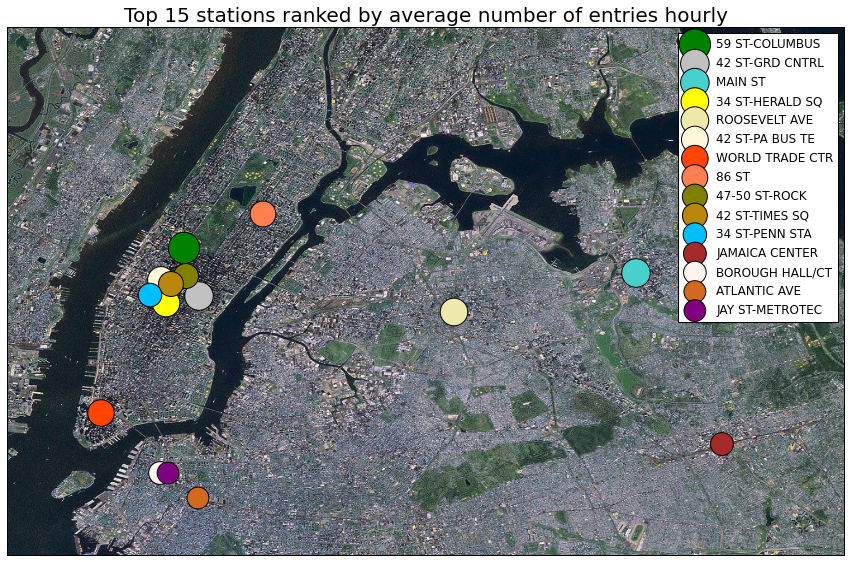

In [109]:
plt.figure(figsize=(15,15))
map = Basemap(projection='cyl',resolution = 'h',
                llcrnrlon = -74.0414, #ll.lon
                llcrnrlat = 40.6650, # ll.lat
                urcrnrlon = -73.7601, #ur.lon
                urcrnrlat = 40.8424, # ur.lat
                 )

map.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= True)

for stat in result.station.unique():
        x, y = map(result[result.station==stat].longitude,result[result.station==stat].latitude)
        size=result[result.station==stat].ENTRIESn_hourly/result.ENTRIESn_hourly.sum()
        maps = map.scatter(x, y, marker="o", alpha=1,c=dict_color[stat],label=stat,s=size*10000)
        
plt.legend(scatterpoints=1, bbox_to_anchor=(1,1))
plt.title("Top 15 stations ranked by average number of entries hourly",fontsize=20)
plt.show()

The busiest stations are located in Midtown, the financial district, and at the World trade center. We can also see hubs in Brooklyn and Queens. 

# Section 4. Conclusion

Based on the statistical test in section 1, people ride the subway more often when it's raining than when it's not raining. To get to this conclusion we have used Mann-Whitney U-test because the underlying data was not normally distributed. The null hypothesis, which states that the distribution of the ENTRIESn_hourly for rainy day and non-rainy day is the same, has been rejected. 
The average number of hourly entries for rainy days tends to be higher than for non rainy days (2028.20 for rainy days and 1845.54 for non-rainy days).

If we look at the linear regression models, the coefficient for the 'rain' variable is always positive. This means that the number of entries hourly is higher when it's raining. It confirms the conclusion from the statistical test. However the coefficient for 'precipi' is negative, which probably means that the number of entries tends to decrease when the rain's intensity is very high.

# Section 5. Reflection

As mentioned in section 2: Linear Regression, the model could definitely be improved. The model explains only 47.7% of the variance. In the visulalization section, we have observed that there is no linear relation between hour and ENTRIESn_hourly. It would be interesting to try a polynomial transformation on the variable hour. We have also obseverved the average number of entries hourly is very different between the weekend and weekdays. We should definitly try to include this variable in the model.

However maximazing R-squared can't be the only goal. Our model might have a high R-squared but have problems generalizing. That's why for feature selections, we should create a train set and test set. We could train the model on the training set, predict the outcome on the test set, and compute the residual standard error (RSE) on the test set to make sure the RSE is decreasing and we don't overfit.